# Learned Sensing Matrix

We got an encoder-decoder like system set up using a similar architecture with DeepCodec. Now let's grab the sensing matrix, load it into MATLAB, and see if we can get better results using a learned sensing matrix on MNIST!

In [24]:
import torch
from torch import nn
from glob import glob

In [59]:
ORIGINAL_SIZE = 28

In [25]:
class WFUMNISTCodec(nn.Module):
    """A NN that definitely won't work, lmao, Test our dataloader."""
    def __init__(self, original_res, sensing_res):
        """Makes a FCN type architecture, takes in picture dimension d x d"""
        super(WFUMNISTCodec, self).__init__()
        
        self.m = sensing_res
        # Sensing matrix
        self.sensing = torch.nn.Linear(original_res * original_res, sensing_res * sensing_res, bias=False)
        
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 8, kernel_size=4, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(4, 1, kernel_size=3, stride=1, padding=1)
        self.upsample = torch.nn.UpsamplingBilinear2d(size=(original_res, original_res))
        
    def forward(self, x):
        # Apply the sensing matrix without activation, reshape back to image-like for FCN
        x = self.sensing(x.view(x.shape[0], -1)).view(x.shape[0], 1, self.m, self.m)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return self.upsample(x)

In [28]:
!pwd

/home/robocup/am254


In [39]:
torchmodels = list(sorted(glob("/home/robocup/am254/models/wfunetsmall*.torchmodel")))

In [40]:
undersamplings = [int(t.replace(".torchmodel", "").split('_')[-1]) for t in torchmodels]

In [41]:
undersamplings

[12, 16, 20, 24, 4, 8]

We want to sort by how bad we are undersampling.

In [54]:
torchmodels, undersamplings = zip(*list(sorted(zip(torchmodels, undersamplings), key=lambda x: x[1])))

In [56]:
undersamplings

(4, 8, 12, 16, 20, 24)

## Getting the Sensing Matrix

The sensing matrix is just the first fully connected layer that maps MNIST into a lower dimensional space. Let's return this and serialize it into something that MATLAB can load.

In [42]:
def get_sensing_from_model(model):
    params = list(model.parameters())
    return params[0].detach().cpu().numpy()

In [57]:
models = [torch.load(t) for t in torchmodels]

In [43]:
sensing_layers = [get_sensing_from_model(torch.load(t)) for t in torchmodels] 

In [44]:
for sensing_matrix in sensing_layers:
    print(sensing_matrix.shape)

(144, 784)
(256, 784)
(400, 784)
(576, 784)
(16, 784)
(64, 784)


In [36]:
sensing_layers

[]

In [45]:
from scipy.io import savemat

In [47]:
sense_map = {}
for dim, mat in zip(undersamplings, sensing_layers):
    sense_map['sensematrix' + str(dim)] = mat
savemat('small_conv_sensing_matrices.mat', sense_map)

# Visualizing Model Results

Now let's plot the predictions for each sparsity for a very small model trained after 30 epochs.


In [48]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch import distributions as ds
from torch.utils import data as utils

import numpy as np
import scipy
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [50]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
batch_size=128, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device: %s' % str(device))

Using device: cuda:0


In [51]:
random_test_X, random_test_y = None, None
for X, y in train_loader:
    random_test_X = X.clone()
    random_test_y = X.clone()
    break

# random_test_X, random_test_y = None, None
# for X, y in test_loader:
#     random_test_X = X.clone()
#     random_test_y = X.clone()
#     break

In [60]:
test_y_hats = [model(random_test_X.to(device)).detach() for model in models]
result_images = [test_y_hat.permute(0, 3, 1, 2).cpu().numpy().reshape(test_y_hat.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE).swapaxes(1, 2) for test_y_hat in test_y_hats]
actual = random_test_y.permute(0, 3, 1, 2).cpu().numpy().reshape(random_test_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE).swapaxes(1, 2)

In [68]:
len(result_images)

6

In [90]:
def plot_examples(index_lst):
    SIZE = 12
    n_models = len(result_images)
    k = len(index_lst)
    plt.figure(figsize=(SIZE * n_models, SIZE * k))  
    print(n_models)
    for i, index in enumerate(index_lst):
        for idx, result_image in enumerate(result_images):
            # Get minimum of the result and the real image to use same colorbar colors
            # Write titles if it is the first one
            plt.subplot(k, n_models, n_models * i + 1 + idx)
            
            if i == 0:
                undersample_rate = float(undersamplings[idx] ** 2) / ORIGINAL_SIZE ** 2
                plt.title('Undersample = %0.2f' % undersample_rate, fontsize=50)
            
            res = (((result_image[index] + 0.1307)))
            # plt.imshow(res, cmap='gray', vmin=min_val, vmax=max_val)
            plt.imshow(res, cmap='gray')
            # plt.colorbar()
            plt.autoscale(False)

        plt.subplot(k, n_models, n_models * (1 + i) )
        a = ((actual[index] + 0.1307))
        # plt.imshow(a, cmap='gray', vmin=min_val, vmax=max_val)
        plt.imshow(a, cmap='gray')
        # plt.colorbar()
        plt.autoscale(False)
        
    plt.show()

6


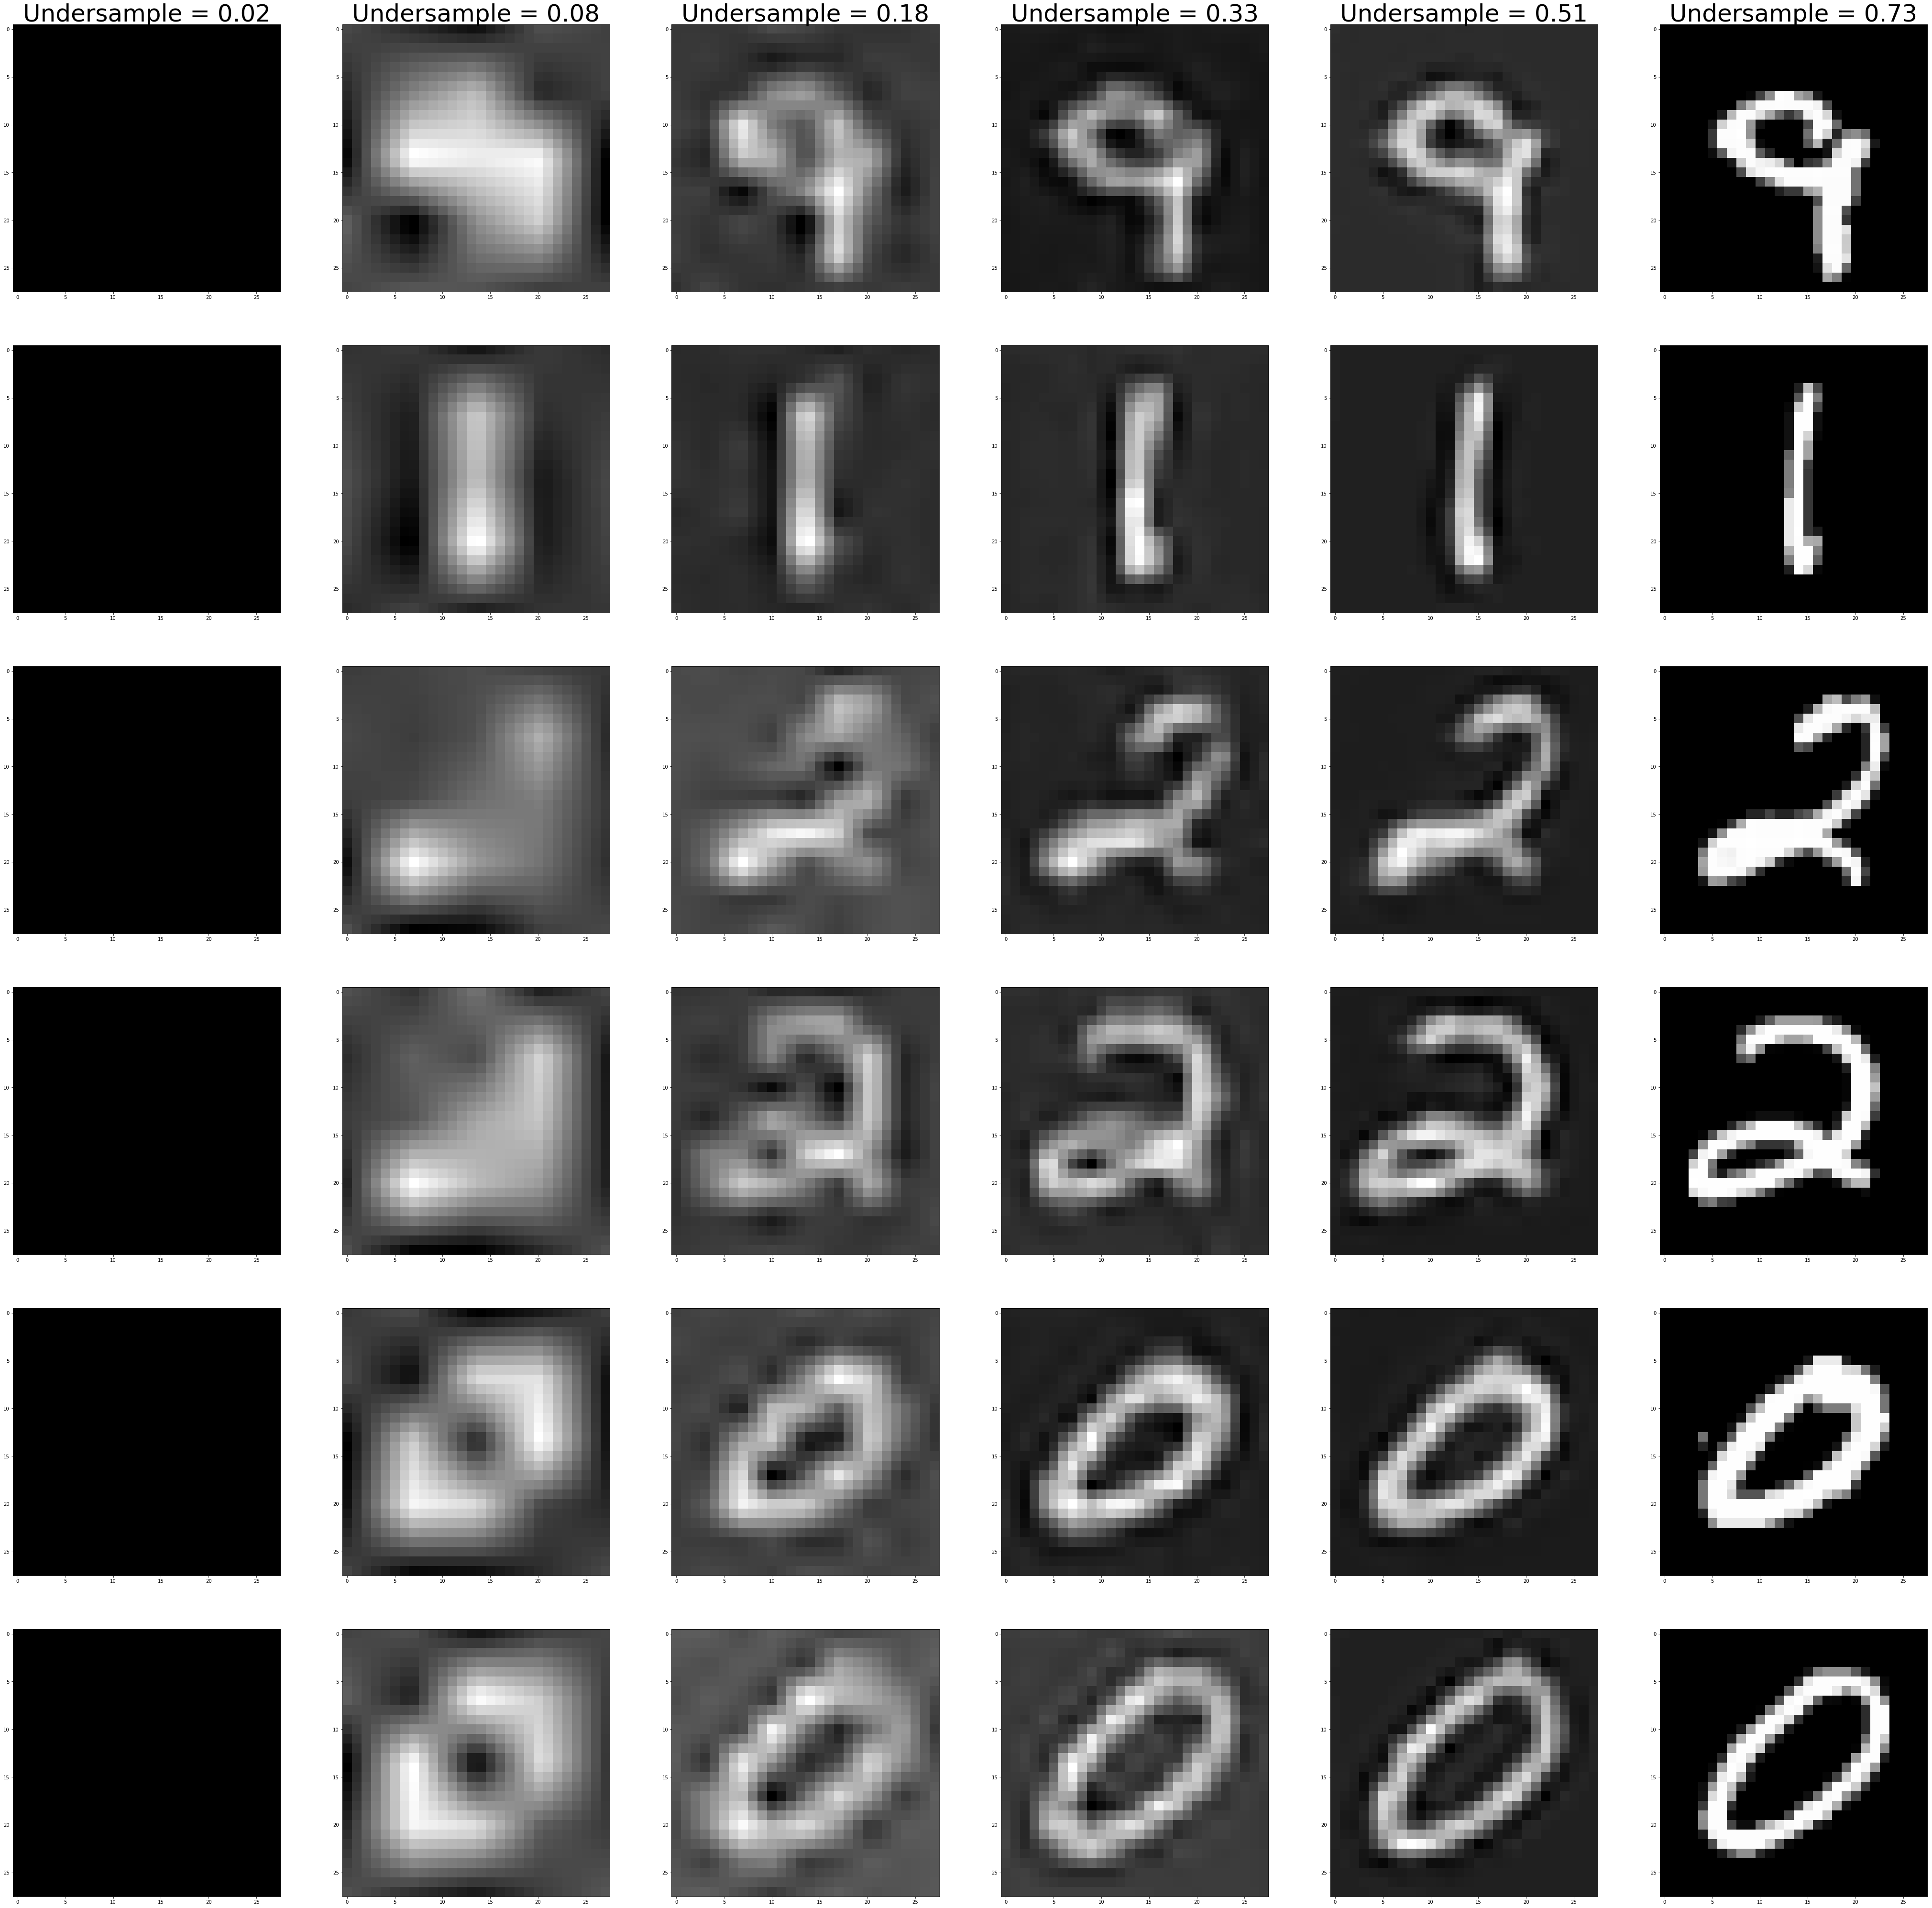

In [91]:
plot_examples([1, 2, 3, 4, 5, 6])